### Working code for vdiff1 vs vdiff2 based param backtracking
### With 3 sigma ellipsoid and weights

#### Ziqing (Anney) Ye

Update 4/26/2024: Make use of Laszlo's refactored binaries library

Update 5/1/2024: made additional plots

Update 5/7/2024: added weights based on covariance matrix

Update 5/13/2024: cutoff based on distance

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
from sklearn.neighbors import KDTree

In [2]:
from binaries import *

### Sample the binary parameters using Lazslo's refactored binaries module

In [3]:
N_stars = 1000000

Os = OrbitSampler() #samples the binary parameters
binary = Os.sample(size=N_stars) #creates a set of binary stars
print(binary)

In [ ]:
#[TODO] figure out how to save a simulation so we don't have to re-sample every time

### Functions for generating a mask of neighbors around a given point on the vdiff vs vdiff space

In [4]:
#based on the vdiff vs vdiff plot without noise, 
#do the ellipsoid thing given an arbitrary coordinate (i.e. an actual measurement)

def rv_error(abs_magnitude, DM=19.2):
    #the error (variance) in radial velocity
    apparent_magnitude = abs_magnitude + DM
    rv_err = np.exp(0.96 * apparent_magnitude - 18.8)
    #If the star is brighter, the magnitude is more negative ->smaller error, makes sense
    return rv_err

#steps in making this work:
#1. compute the covariance vector of the data point (single point) analytically based on RV errors
#2. use KD tree to roughly filter out simulated datapoints nearby in a circle
#3. transform nearby points into a new space (where covariance ellpsoid becomes unit circle),
#and find masks of points inside the unit circle (mask of points inside ellipsoid)
#4.[TODO] (or concurrently with 3) get weights of these points based on a multivariate gaussian formula
#5.[TODO] based on these masks & weights, create weighted histograms of the orbital parameters

def cov_analytical(sig0, sig1, sig2):
    cov_analy = np.array([[sig1**2+sig0**2,sig0**2],[sig0**2,sig2**2+sig0**2]])
    return cov_analy


def get_neighbors(datapoint, vdiffs, datapoint_sigma=1, stdev_thresh=3): #max_num_neighbors=30000):
    '''
    input: 
    a datapoint in vdiff vs vdiff space, 
    the simulated vdiff vs vdiff map,
    standard deviation (in velocity unit) for the ellipsoid,
    standard deviation cutoff for the ellipsoid (e.g. 1sigma, 2sigma, 3sigma, etc)
    
    returns: 
    - ind: index array of the (max_num_neighbors)nearest neighbors
    - mask: a mask of the simulated datapoints within (stdev_thresh) sigma of the covariance (boolean array, size of ind array)
    - weights to each of the datapoints within the mask based on covariance matrix
    '''
    
    #returns a mask of points that fall inside 3 stdev covariance ellipsoid, and weights for each point
    assert(datapoint.shape[0]==vdiffs.shape[0]) #makes it generalizable so we can have e.g. 2, 3, 4, or 5+ observations
    
    cov = cov_analytical(datapoint_sigma,datapoint_sigma,datapoint_sigma) #[TODO] this is only for 2D, 
    #^ might need to fix this so it's generalizable to more dimensions
    eigv, vec = np.linalg.eig(cov)
    eigv_sqrt = np.sqrt(eigv) #major/minor axis length of the stdev ellipsoid
    
    #first do coarse filtering
    X = np.transpose(vdiffs)
    tree = KDTree(X) #this is sklearn's KDTree
    radii = np.max(eigv_sqrt)*stdev_thresh
    #dist, ind = tree.query(np.array([datapoint]), k=max_num_neighbors) #this is older version
    #print(dist.shape, ind.shape)
    
    ind = tree.query_radius(np.array([datapoint]), r=radii) #syntax note: this is a SKLearn kdtree! NOT scipy
    #print(ind[0].shape, ind[0].dtype, ind[0]) #sklearn's query_radius returns (an object containing) the array
    ind=ind[0] #the original ind[0] is the actual ndarray
    
    gaussian = scipy.stats.multivariate_normal(mean=datapoint, cov=cov) #scipy stats
    weights = gaussian.pdf(np.transpose(vdiffs[:,ind]))

    #Transform these roughly filtered points into new space
    
    scaled_eigenvec = np.zeros(vec.shape)
    scaled_eigenvec[:,0] = vec[:,0]*eigv_sqrt[0]
    scaled_eigenvec[:,1] = vec[:,1]*eigv_sqrt[1]
    
    trans = transform_points(vdiffs[:,ind], datapoint, scaled_eigenvec)
    mask = (np.sum(trans**2, axis=0)<=stdev_thresh) #equiv to: mask = (trans[0,:]**2+trans[1,:]**2 <= 1)

    return ind, mask, weights

    
def transform_points(points, center, cov_eig_matrix):
    transformed = np.copy(points)
    transformed[0,:] -= center[0] #center at 0
    transformed[1,:] -= center[1] #center at 0
    
    #multiply by the inverse of cov matrix
    inv = np.linalg.inv(cov_eig_matrix)
    return np.transpose(np.transpose(transformed).dot(inv.T))



'''
Sample usage:


datapoint = np.array([-5, -10])#suppose vdiff1=20, vdiff2=-10
datapoint_err = rv_error(binary.lum[5])**0.5 #pick a random measurement error sigma

vdiff_1 = obs2.v_los - obs1.v_los
vdiff_2 = obs3.v_los - obs1.v_los

vdiffs = np.array([vdiff_1, vdiff_2])

dst, indx, msk, wts = get_neighbors(datapoint, vdiffs, datapoint_err)



'''


'\nSample usage:\n\n\ndatapoint = np.array([-5, -10])#suppose vdiff1=20, vdiff2=-10\ndatapoint_err = rv_error(binary.lum[5])**0.5 #pick a random measurement error sigma\n\nvdiff_1 = obs2.v_los - obs1.v_los\nvdiff_2 = obs3.v_los - obs1.v_los\n\nvdiffs = np.array([vdiff_1, vdiff_2])\n\ndst, indx, msk, wts = get_neighbors(datapoint, vdiffs, datapoint_err)\n\n\n\n'

### Experiment 1: using 3 simulated observations at t=0, t=30 days, and t=90 days

In [5]:
obs1 = binary.observe(0)
obs2 = binary.observe(30) #t in unit of days!!
obs3 = binary.observe(90)

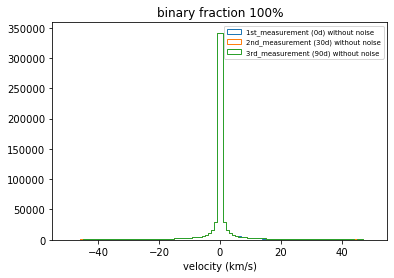

In [6]:
hist_bins = np.linspace(-50,50,101)
plt.hist(obs1.v_los,bins=hist_bins,histtype='step',label='1st_measurement (0d) without noise')
plt.hist(obs2.v_los,bins=hist_bins,histtype='step',label='2nd_measurement (30d) without noise')
plt.hist(obs3.v_los,bins=hist_bins,histtype='step',label='3rd_measurement (90d) without noise')

plt.xlabel('velocity (km/s)')
plt.title('binary fraction 100%')
plt.legend(fontsize='x-small')
#plt.semilogy()

(2, 1000000)


(-200, 200)

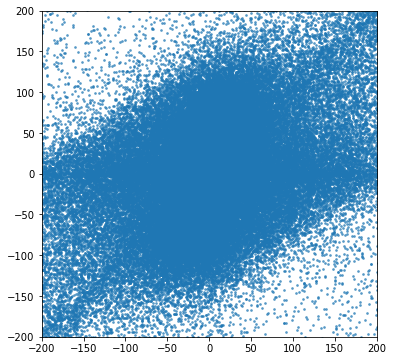

In [7]:
vdiff_A1 = obs2.v_los - obs1.v_los
vdiff_A2 = obs3.v_los - obs1.v_los

vdiffsA = np.array([vdiff_A1, vdiff_A2]) #30-0 vs 90-0
print(vdiffsA.shape)

figure(figsize=(6, 6))
plt.scatter(vdiff_A1, vdiff_A2, s=3, alpha=0.6)
plt.xlim(-200,200)
plt.ylim(-200,200)


In [8]:
datapoint_err = rv_error(binary.lum[5])**0.5 #pick a random measurement error sigma for now

#indx is an index array on vdiffs, msk is a boolean array on indx. Use indx[msk] to get elements in ellipsoid
indx, msk, wt = get_neighbors(np.array([20,40]), vdiffsA, datapoint_err, stdev_thresh=2)
print('num elements in msk:', msk.sum())

indx2, msk2, wt2 = get_neighbors(np.array([3,-10]), vdiffsA, datapoint_err, stdev_thresh=2) 
print('num elements in msk2', msk2.sum())

indx3, msk3, wt3 = get_neighbors(np.array([-1,1]), vdiffsA, datapoint_err, stdev_thresh=2) 
print('num elements in msk3', msk3.sum())

indx4, msk4, wt4 = get_neighbors(np.array([1,1]), vdiffsA, datapoint_err, stdev_thresh=2)
print('num elements in msk4:', msk4.sum())


num elements in msk: 82
num elements in msk2 139
num elements in msk3 28081
num elements in msk4: 769316


(277,)
(277,)


(-50, 50)

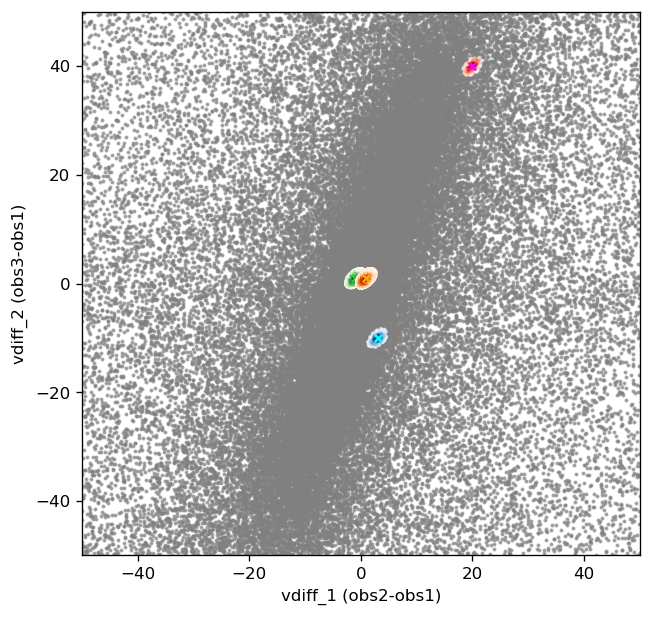

In [9]:
figure(figsize=(6, 6), dpi=120)

plt.scatter(vdiffsA[0], vdiffsA[1], s=2, color='grey', alpha=0.6)

print(vdiffsA[0,indx].shape)
print(wt.shape)


plt.scatter(vdiffsA[0,indx[msk]], vdiffsA[1,indx[msk]], c=wt[msk], cmap='Reds', s=2, alpha=0.6)
plt.scatter(20, 40, marker='x', s=20, color='magenta')

plt.scatter(vdiffsA[0,indx2[msk2]], vdiffsA[1,indx2[msk2]], c=wt2[msk2], cmap='Blues', s=2, alpha=0.6)
plt.scatter(3, -10, marker='x', s=20, color='cyan')

plt.scatter(vdiffsA[0,indx3[msk3]], vdiffsA[1,indx3[msk3]], c=wt3[msk3], cmap='Greens', s=2, alpha=0.6)
plt.scatter(-1, 1, marker='x', s=20, color='limegreen')

plt.scatter(vdiffsA[0,indx4[msk4]], vdiffsA[1,indx4[msk4]], c=wt4[msk4], cmap='Oranges', s=2, alpha=0.6)
plt.scatter(1, 1, marker='x', s=20, color='orange')

plt.xlabel('vdiff_1 (obs2-obs1)')
plt.ylabel('vdiff_2 (obs3-obs1)')

plt.xlim(-50,50)
plt.ylim(-50,50)

(-15, 9)

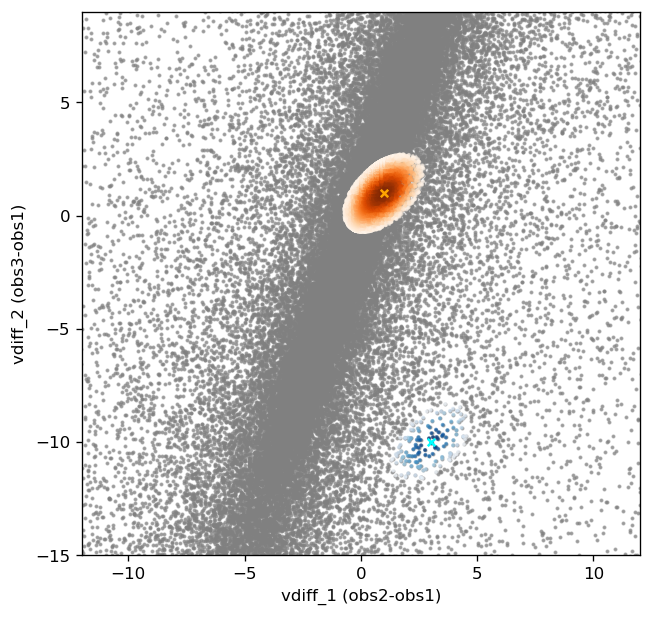

In [10]:
figure(figsize=(6, 6), dpi=120)

plt.scatter(vdiffsA[0], vdiffsA[1], s=2, color='grey', alpha=0.6)

plt.scatter(vdiffsA[0,indx2[msk2]], vdiffsA[1,indx2[msk2]], c=wt2[msk2], cmap='Blues', s=2, alpha=0.6)
plt.scatter(3, -10, marker='x', s=20, color='cyan')

plt.scatter(vdiffsA[0,indx4[msk4]], vdiffsA[1,indx4[msk4]], c=wt4[msk4], cmap='Oranges', s=2, alpha=0.6)
plt.scatter(1, 1, marker='x', s=20, color='orange')

plt.xlabel('vdiff_1 (obs2-obs1)')
plt.ylabel('vdiff_2 (obs3-obs1)')

plt.xlim(-12,12)
plt.ylim(-15,9)

(-10, 10)

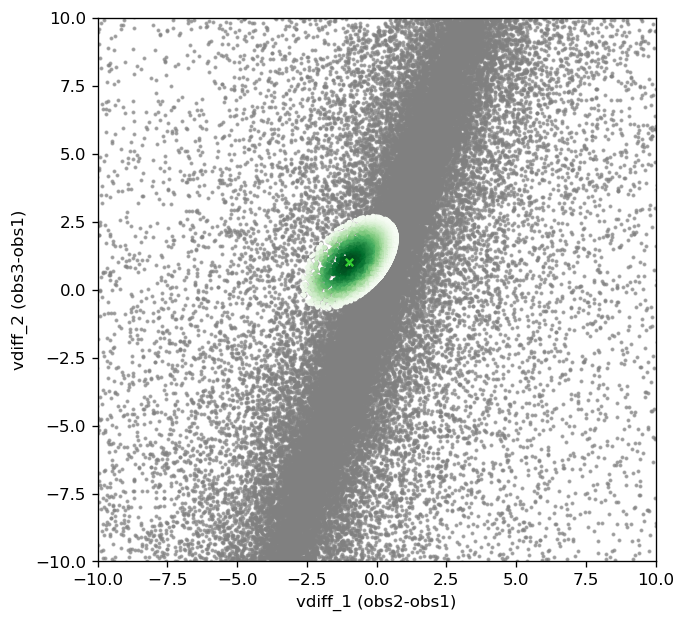

In [11]:
figure(figsize=(6, 6), dpi=120)

plt.scatter(vdiffsA[0], vdiffsA[1], s=2, color='grey', alpha=0.6)

plt.scatter(vdiffsA[0,indx3[msk3]], vdiffsA[1,indx3[msk3]], c=wt3[msk3], cmap='Greens', s=2)
plt.scatter(-1, 1, marker='x', s=20, color='limegreen')


plt.xlabel('vdiff_1 (obs2-obs1)')
plt.ylabel('vdiff_2 (obs3-obs1)')

plt.xlim(-10,10)
plt.ylim(-10,10)

(796625,) (796625,)


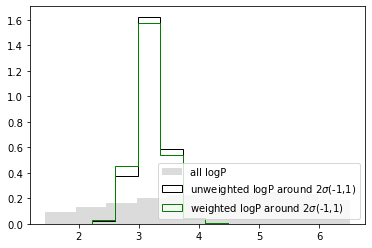

In [12]:
#plot weighted histogram

plt.hist(binary.logP, color='lightgrey', alpha=0.8, label='all logP', density=True)
plt.hist(binary.logP[indx3[msk3]], histtype='step',label='unweighted logP around 2$\sigma$(-1,1)', color='black', density=True)
print(binary.logP[indx3].shape, wt3.shape)
plt.hist(binary.logP[indx3[msk3]], weights=wt3[msk3], histtype='step',label='weighted logP around 2$\sigma$(-1,1)', color='green', density=True)

plt.legend(loc='lower right')

Text(0.5, 0, 'luminosity')

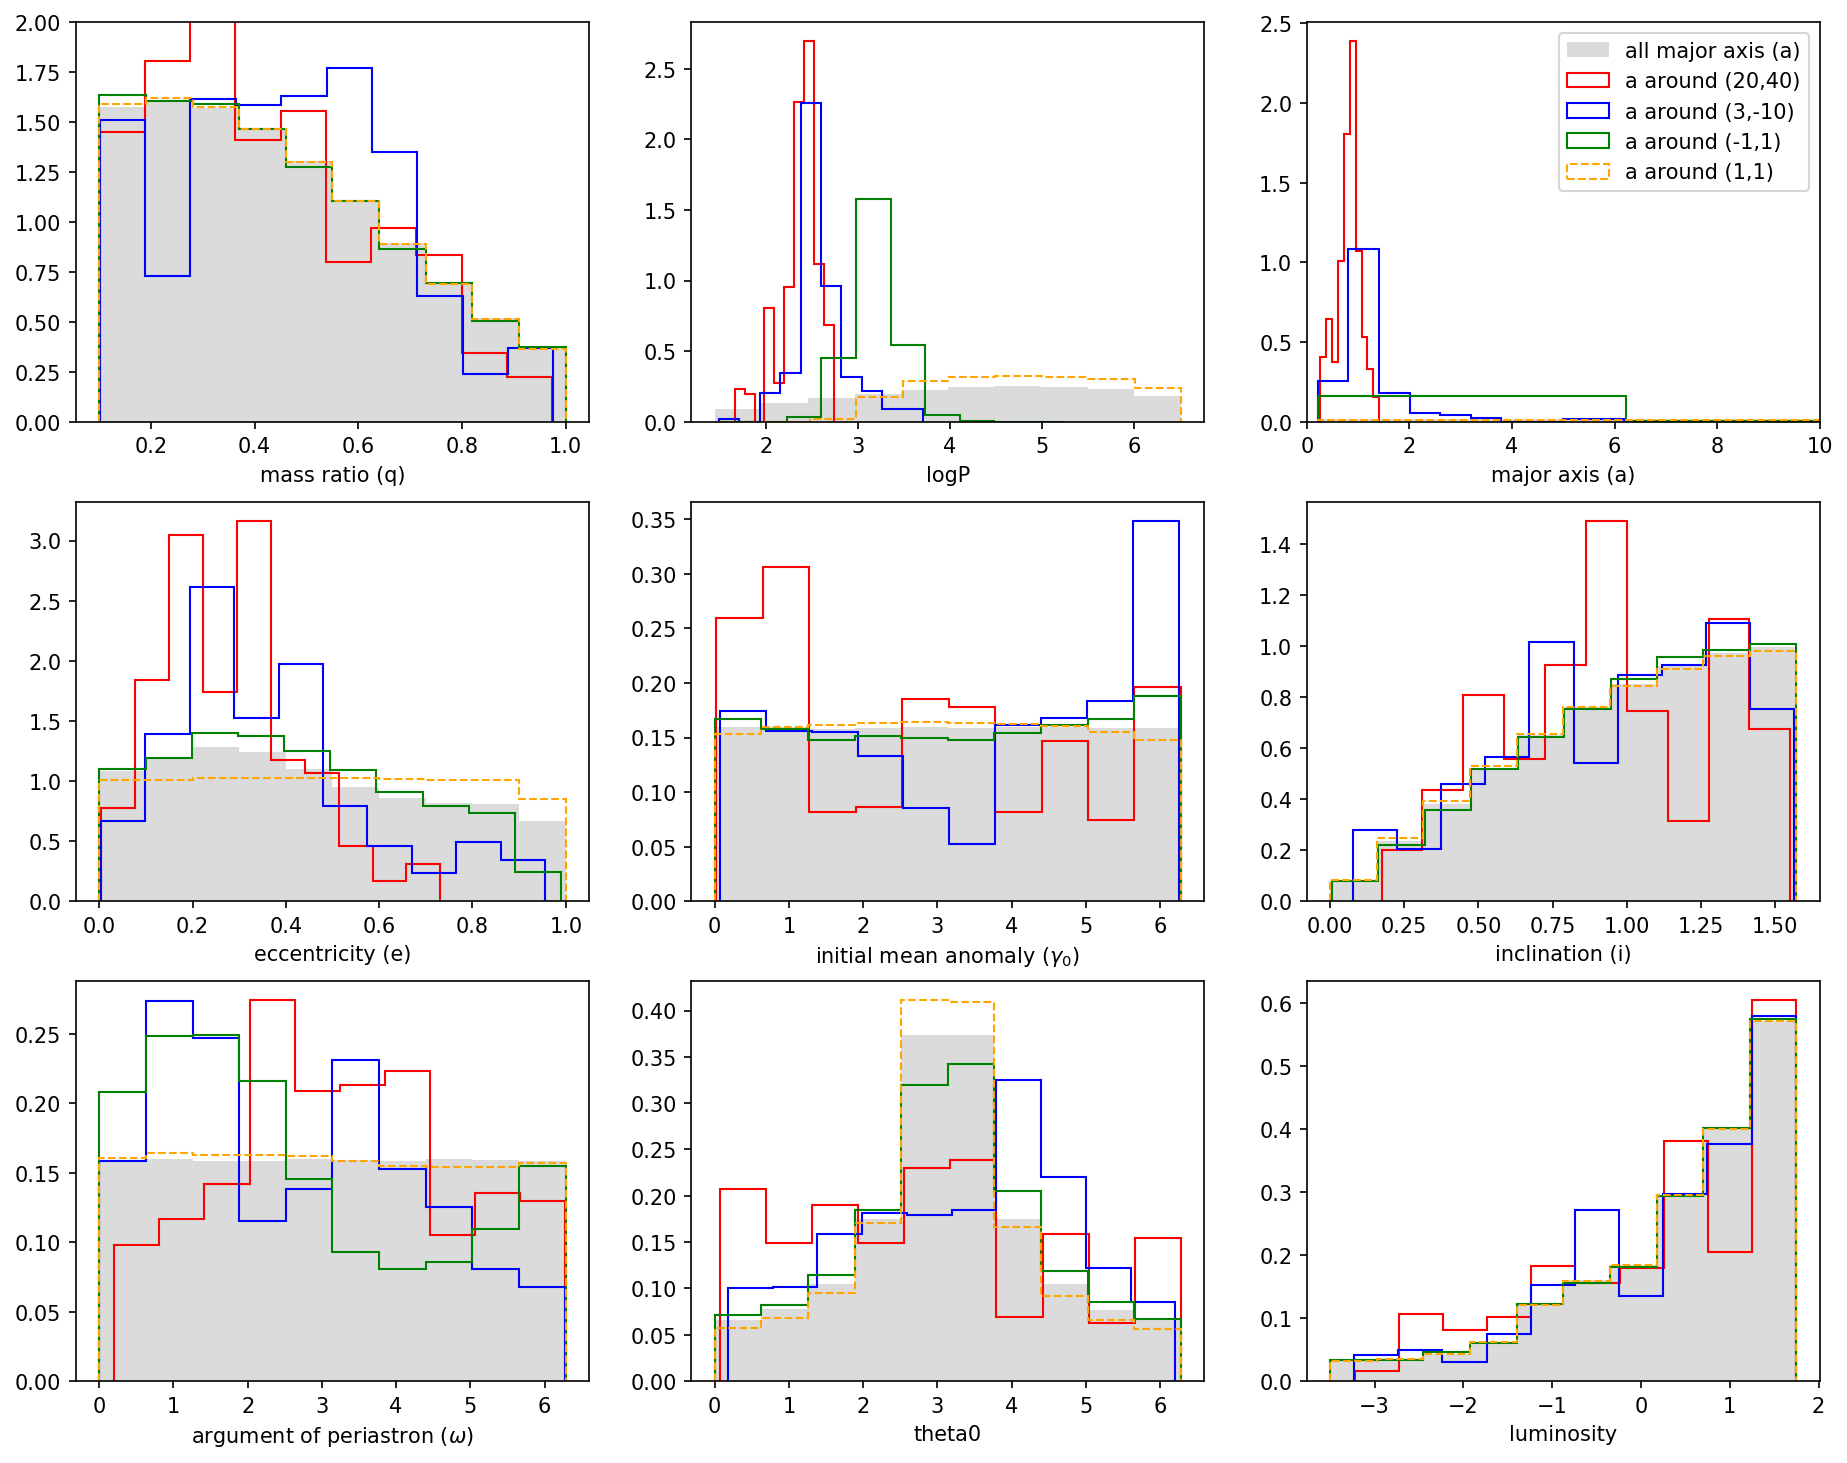

In [13]:
#plot different parameters


fig,axs=plt.subplots(3,3, figsize=(15,12), dpi=150) #set up plot axis &axis range

axs[0,0].hist(binary.q, color='lightgrey', alpha=0.8, label='all mass ratio (q)', density=True)

axs[0,0].hist(binary.q[indx[msk]], histtype='step',weights=wt[msk], label='weighted q around (20,40)', color='red', density=True)
axs[0,0].hist(binary.q[indx2[msk2]], histtype='step',weights=wt2[msk2], label='weighted q around (3,-10)', color='blue', density=True)
axs[0,0].hist(binary.q[indx3[msk3]], histtype='step',weights=wt3[msk3], label='weighted q around (-1,1)', color='green', density=True)
axs[0,0].hist(binary.q[indx4[msk4]], histtype='step',weights=wt4[msk4], label='weighted q around (1,1)', color='orange', linestyle='dashed',density=True)
axs[0,0].set_xlabel('mass ratio (q)')
axs[0,0].set_ylim(0,2)
#axs[0,0].legend()


axs[0,1].hist(binary.logP, color='lightgrey', alpha=0.8, label='all logP', density=True)

axs[0,1].hist(binary.logP[indx[msk]], weights=wt[msk], histtype='step',label='logP around (20,40)', color='red', density=True)
axs[0,1].hist(binary.logP[indx2[msk2]], weights=wt2[msk2], histtype='step',label='logP around (3,-10)', color='blue', density=True)
axs[0,1].hist(binary.logP[indx3[msk3]], weights=wt3[msk3], histtype='step',label='logP around (-1,1)', color='green', density=True)
axs[0,1].hist(binary.logP[indx4[msk4]], weights=wt4[msk4], histtype='step',label='logP around (1,1)', color='orange', linestyle='dashed',density=True)

axs[0,1].set_xlabel('logP')
#axs[0,1].set_ylim(0,2)
#axs[0,1].legend()

axs[0,2].hist(binary.a, color='lightgrey', alpha=0.8, label='all major axis (a)', density=True)
axs[0,2].hist(binary.a[indx[msk]], weights=wt[msk], histtype='step',label='a around (20,40)', color='red', density=True)
axs[0,2].hist(binary.a[indx2[msk2]], weights=wt2[msk2], histtype='step',label='a around (3,-10)', color='blue', density=True)
axs[0,2].hist(binary.a[indx3[msk3]], weights=wt3[msk3], histtype='step',label='a around (-1,1)', color='green', density=True)
axs[0,2].hist(binary.a[indx4[msk4]], weights=wt4[msk4], histtype='step',label='a around (1,1)', color='orange', linestyle='dashed',density=True)
axs[0,2].set_xlim(0,10) #this originally goes up to 400 for all major axis histogram
axs[0,2].set_xlabel('major axis (a)')
axs[0,2].legend()


axs[1,0].hist(binary.e, color='lightgrey', alpha=0.8, label='all eccentricity (e)', density=True)
axs[1,0].hist(binary.e[indx[msk]], weights=wt[msk], histtype='step',label='e around (20,40)', color='red', density=True)
axs[1,0].hist(binary.e[indx2[msk2]], weights=wt2[msk2], histtype='step',label='e around (3,-10)', color='blue', density=True)
axs[1,0].hist(binary.e[indx3[msk3]], weights=wt3[msk3], histtype='step',label='e around (-1,1)', color='green', density=True)
axs[1,0].hist(binary.e[indx4[msk4]], weights=wt4[msk4], histtype='step',label='e around (1,1)', color='orange', linestyle='dashed',density=True)
axs[1,0].set_xlabel('eccentricity (e)')
#axs[1,0].legend()

axs[1,1].hist(binary.gamma0, color='lightgrey', alpha=0.8, label='all gamma0', density=True)
axs[1,1].hist(binary.gamma0[indx[msk]], weights=wt[msk], histtype='step',label='gamma0 around (20,40)', color='red', density=True)
axs[1,1].hist(binary.gamma0[indx2[msk2]], weights=wt2[msk2], histtype='step',label='gamma0 around (3,-10)', color='blue', density=True)
axs[1,1].hist(binary.gamma0[indx3[msk3]], weights=wt3[msk3], histtype='step',label='gamma0 around (-1,1)', color='green', density=True)
axs[1,1].hist(binary.gamma0[indx4[msk4]], weights=wt4[msk4], histtype='step',label='gamma0 around (1,1)', color='orange', linestyle='dashed',density=True)
axs[1,1].set_xlabel('initial mean anomaly ($\gamma_0$)')
#axs[1,1].legend()

axs[1,2].hist(binary.i, color='lightgrey', alpha=0.8, label='all inclination (i)', density=True)
axs[1,2].hist(binary.i[indx[msk]], weights=wt[msk], histtype='step',label='i around (20,40)', color='red', density=True)
axs[1,2].hist(binary.i[indx2[msk2]], weights=wt2[msk2], histtype='step',label='i around (3,-10)', color='blue', density=True)
axs[1,2].hist(binary.i[indx3[msk3]], weights=wt3[msk3], histtype='step',label='i around (-1,1)', color='green', density=True)
axs[1,2].hist(binary.i[indx4[msk4]], weights=wt4[msk4], histtype='step',label='i around (1,1)', color='orange', linestyle='dashed',density=True)
axs[1,2].set_xlabel('inclination (i)')
#axs[1,2].legend()


axs[2,0].hist(binary.omega, color='lightgrey', alpha=0.8, label='all omega', density=True)
axs[2,0].hist(binary.omega[indx[msk]], weights=wt[msk], histtype='step',label='omega around (20,40)', color='red', density=True)
axs[2,0].hist(binary.omega[indx2[msk2]], weights=wt2[msk2], histtype='step',label='omega around (3,-10)', color='blue', density=True)
axs[2,0].hist(binary.omega[indx3[msk3]], weights=wt3[msk3], histtype='step',label='omega around (-1,1)', color='green', density=True)
axs[2,0].hist(binary.omega[indx4[msk4]], weights=wt4[msk4], histtype='step',label='omega around (1,1)', color='orange', linestyle='dashed',density=True)
axs[2,0].set_xlabel('argument of periastron ($\omega$)')
#axs[2,0].legend()

axs[2,1].hist(binary.theta0, color='lightgrey', alpha=0.8, label='all theta0', density=True)
axs[2,1].hist(binary.theta0[indx[msk]], weights=wt[msk], histtype='step',label='theta0 around (20,40)', color='red', density=True)
axs[2,1].hist(binary.theta0[indx2[msk2]], weights=wt2[msk2], histtype='step',label='theta0 around (3,-10)', color='blue', density=True)
axs[2,1].hist(binary.theta0[indx3[msk3]], weights=wt3[msk3], histtype='step',label='theta0 around (-1,1)', color='green', density=True)
axs[2,1].hist(binary.theta0[indx4[msk4]], weights=wt4[msk4], histtype='step',label='theta0 around (1,1)', color='orange', linestyle='dashed',density=True)
axs[2,1].set_xlabel('theta0')
#axs[1,1].legend()


#luminosity should have nothing to do with binary velocity (uncorrelated)--negative control
axs[2,2].hist(binary.lum, color='lightgrey', alpha=0.8, label='all luminosity', density=True)
axs[2,2].hist(binary.lum[indx[msk]], weights=wt[msk], histtype='step',label='lum around (20,40)', color='red', density=True)
axs[2,2].hist(binary.lum[indx2[msk2]], weights=wt2[msk2], histtype='step',label='lum around (3,-10)', color='blue', density=True)
axs[2,2].hist(binary.lum[indx3[msk3]], weights=wt3[msk3], histtype='step',label='lum around (-1,1)', color='green', density=True)
axs[2,2].hist(binary.lum[indx4[msk4]], weights=wt4[msk4], histtype='step',label='lum around (1,1)', color='orange', linestyle='dashed',density=True)
axs[2,2].set_xlabel('luminosity')
#axs[2,2].legend()




In [ ]:
#independent variables (independent from one another): q, P, gamma0, i, omega, luminosity
#a & e is based on q, P (e is based on a);
#theta is based on gamma & e

### Todo: try different cadence and see how that impacts things

In [14]:
obs4 = binary.observe(182) #roughly half a year

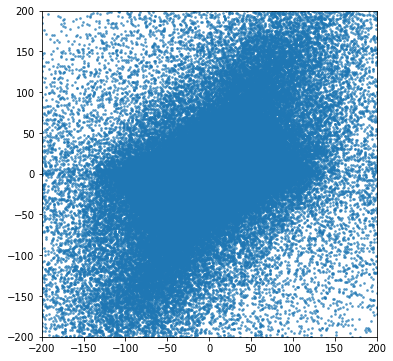

In [15]:
vdiff_B1 = obs3.v_los - obs1.v_los #90 days
vdiff_B2 = obs4.v_los - obs1.v_los #182 days

figure(figsize=(6, 6))
plt.scatter(vdiff_B1, vdiff_B2, s=3, alpha=0.6)
plt.xlim(-200,200)
plt.ylim(-200,200)
vdiffsB = np.array([vdiff_B1, vdiff_B2]) #90-0 vs 182-0

(277,)
(277,)


(-200, 200)

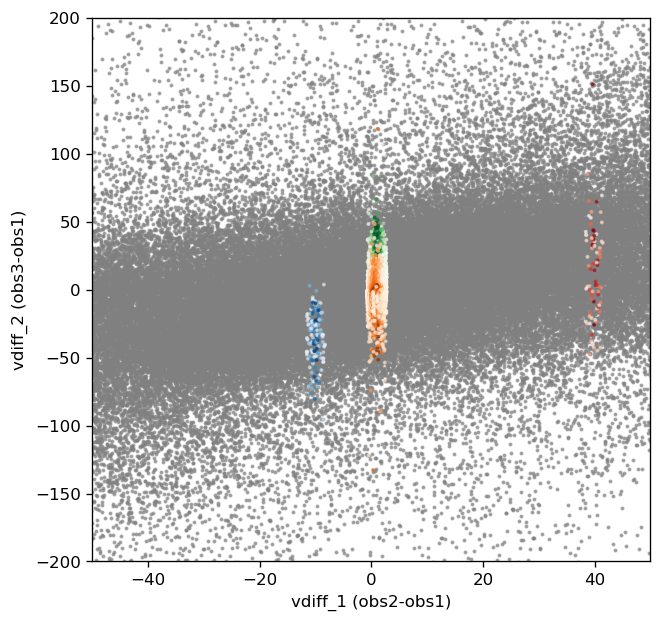

In [27]:
#experiment: see stars that appear close in the previous map still appears close in this new observation

figure(figsize=(6, 6), dpi=120)

plt.scatter(vdiffsB[0], vdiffsB[1], s=2, color='grey', alpha=0.6)

print(vdiffsB[0,indx].shape)
print(wt.shape)


plt.scatter(vdiffsB[0,indx[msk]], vdiffsB[1,indx[msk]], c=wt[msk], cmap='Reds', s=2, alpha=0.6)

plt.scatter(vdiffsB[0,indx2[msk2]], vdiffsB[1,indx2[msk2]], c=wt2[msk2], cmap='Blues', s=2, alpha=0.6)

plt.scatter(vdiffsB[0,indx3[msk3]], vdiffsB[1,indx3[msk3]], c=wt3[msk3], cmap='Greens', s=2, alpha=0.6)

plt.scatter(vdiffsB[0,indx4[msk4]], vdiffsB[1,indx4[msk4]], c=wt4[msk4], cmap='Oranges', s=2, alpha=0.6)

plt.xlabel('vdiff_1 (obs2-obs1)')
plt.ylabel('vdiff_2 (obs3-obs1)')

plt.xlim(-50,50)
plt.ylim(-200,200)

In [24]:
datapoint_err = rv_error(binary.lum[5])**0.5 #pick a random measurement error sigma for now

star_1_vA = vdiffsA[:,indx[msk][0]] #try to see what the same star from above looks like with a diff cadence
star_1_vB = vdiffsB[:,indx[msk][0]] #try to see what the same star from above looks like with a diff cadence

print('star vdiff with 0-30-90:', star_1_vA,)
print('same star vdiff with 0-90-182', star_1_vB)

#indxB is an index array on vdiffs, mskB is a boolean array on indxB. Use indxB[mskB] to get elements in ellipsoid
indxB, mskB, wtB = get_neighbors(np.array([20,40]), vdiffsB, datapoint_err, stdev_thresh=2)
print('num elements in mskB:', mskB.sum())

indxB2, mskB2, wtB2 = get_neighbors(np.array([3,-10]), vdiffsB, datapoint_err, stdev_thresh=2) 
print('num elements in mskB2', mskB2.sum())

indxB3, mskB3, wtB3 = get_neighbors(np.array([-1,1]), vdiffsB, datapoint_err, stdev_thresh=2) 
print('num elements in mskB3', mskB3.sum())

indxB4, mskB4, wtB4 = get_neighbors(np.array([1,1]), vdiffsB, datapoint_err, stdev_thresh=2)
print('num elements in mskB4:', mskB4.sum())


star vdiff with 0-30-90: [18.54749323 38.71054716]
same star with 0-90-182 [38.71054716  2.23511401]
num elements in mskB: 116
num elements in mskB2 185
num elements in mskB3 11501
num elements in mskB4: 739766
